In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_profiling as prof
from sklearn.base import BaseEstimator, TransformerMixin
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 300)
import datetime

In [2]:
df_tdf = pd.read_csv('TDF.csv',parse_dates=['Date'])
df_pazzo = pd.read_csv('PAZZO.csv',parse_dates=['Date'])

In [3]:
df_tdf.tail()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units
5195,DC West,2018-08-27,SKU050,226,226
5196,DC West,2018-09-03,SKU050,288,288
5197,DC West,2018-09-10,SKU050,200,200
5198,DC West,2018-09-17,SKU050,105,105
5199,DC West,2018-09-24,SKU050,100,100


- As here, we would include time information in the data as a feature we can consider this data to be iid.
- Performing 80,20 split

In [4]:
def train_test_split(data,train_period='2018-06-01'):
    #np.random.seed(10) 
    data['train_val'] = np.where(data['Date']<pd.to_datetime(train_period), 't','v')
    return data

In [5]:
df_tdf['DC_SKU']= df_tdf['DC']+'_'+df_tdf['SKU']
df_tdf= train_test_split(df_tdf)

In [6]:
df_tdf['train_val'].value_counts()

t    3500
v    1700
Name: train_val, dtype: int64

In [8]:
# Information on Past purchase oder Units information
def past_purchase_order_units(df,n=1):
    df = df.sort_values(by='Date')
    df['%s_week_before_purchase_units'%str(n)] = df['Purchase Order Units'].shift(n)
    return df
class purchase_order_cat_by_past_nweek(BaseEstimator, TransformerMixin):
    """ Creating distribution of past purchase history by provding mean and std deviation to 
    model as a feature
    This function devides the past weeks order into 4 category and gives avg order in current week based 
    on the past information
    
    """
    
    def __init__(self,n=1,aggtype='mean',iterator='DC_SKU'):
        self.n = n
        self.aggtype = aggtype
        self.iterator = 'DC_SKU'
        
    def past_purchase_order_units(df,n=1):
        df = df.sort_values(by='Date')
        df['%s_week_before_purchase_units'%str(n)] = df['Purchase Order Units'].shift(n)
        return df
    
    def fit(self,X,y=None,*_):
        
        df_temp = X.copy()
        bin_df = pd.DataFrame()
        for it in df_temp[self.iterator].unique():
            temp = df_temp[(df_temp[self.iterator]==it)]
            temp = past_purchase_order_units(temp,self.n)
            try:
                cat_pu,bin_var = pd.qcut(temp['%s_week_before_purchase_units'%str(self.n)],q = 4, labels = [1,2,3,4], retbins = True)
            except:
                try:
                    cat_pu,bin_var = pd.qcut(temp['%s_week_before_purchase_units'%str(self.n)],q = 3, labels = [1,2,3], retbins = True)
                except:
                    try:
                        cat_pu,bin_var = pd.qcut(temp['%s_week_before_purchase_units'%str(self.n)],q = 2, labels = [1,2], retbins = True)
                    except:
                        cat_pu,bin_var = pd.qcut(temp['%s_week_before_purchase_units'%str(self.n)],q = 1, labels = [1], retbins = True)
            tbin_df = pd.DataFrame({'Bin_purchase_order_%s'%str(self.n):bin_var[1:]})
        
        
            temp['Cat'] = cat_pu
            if self.aggtype=='mean':
                tbin_df['values'] = temp.groupby(by='Cat').mean()['Purchase Order Units'].values
            else:
                tbin_df['values'] = temp.groupby(by='Cat').std()['Purchase Order Units'].values
            tbin_df[self.iterator] = it
            bin_df = pd.concat([bin_df,tbin_df],ignore_index=None)
        self.bin_df = bin_df
        return self
    def transform(self,X,*_):
        
        df_temp = X.copy()
        X_ret = pd.DataFrame()
        for it in df_temp[self.iterator].unique():
            #print(it)
            temp = df_temp[(df_temp[self.iterator]==it)]
            temp = past_purchase_order_units(temp,self.n)
            var = '%s_week_before_purchase_units'%str(self.n)
            bin_list =  self.bin_df['Bin_purchase_order_%s'%str(self.n)][self.bin_df[self.iterator]==it].tolist()
            bin_values = self.bin_df['values'][self.bin_df[self.iterator]==it].tolist()
            var_name = '%s_purchase_order_cat_by_past_%s_week'%(self.aggtype,self.n)
            #print(bin_list)
            if len(bin_list)==4:
                temp[var_name] =  np.where(temp[var] <= bin_list[0],bin_values[0],np.where(temp[var] <= bin_list[1],bin_values[1],np.where(temp[var]<= bin_list[2],bin_values[2],bin_values[3])))
            elif len(bin_list)==3:
                temp[var_name] =  np.where(temp[var] <= bin_list[0],bin_values[0],np.where(temp[var] <= bin_list[1],bin_values[1],bin_values[2]))
            elif len(bin_list)==2:
                temp[var_name] =  np.where(temp[var] <= bin_list[0],bin_values[0],bin_values[1])
            else:
                temp[var_name] =  bin_values[0]
            X_ret = pd.concat([X_ret,temp],ignore_index=None)
        return X_ret
    

In [9]:
past_puchase_cat_by1week_mean = purchase_order_cat_by_past_nweek(aggtype='mean')
past_puchase_cat_by1week_std = purchase_order_cat_by_past_nweek(aggtype='std')
past_puchase_cat_by2week_mean = purchase_order_cat_by_past_nweek(aggtype='mean',n=2)
past_puchase_cat_by2week_std = purchase_order_cat_by_past_nweek(aggtype='std',n=2)
past_puchase_cat_by3week_mean = purchase_order_cat_by_past_nweek(aggtype='mean',n=3)
past_puchase_cat_by3week_std = purchase_order_cat_by_past_nweek(aggtype='std',n=3)
past_puchase_cat_by4week_mean = purchase_order_cat_by_past_nweek(aggtype='mean',n=4)
past_puchase_cat_by4week_std = purchase_order_cat_by_past_nweek(aggtype='std',n=4)

In [10]:
train= df_tdf[(df_tdf['train_val']=='t')]
train = past_puchase_cat_by1week_mean.fit_transform(train)
train = past_puchase_cat_by1week_std.fit_transform(train)
train = past_puchase_cat_by2week_mean.fit_transform(train)
train = past_puchase_cat_by2week_std.fit_transform(train)
train = past_puchase_cat_by3week_mean.fit_transform(train)
train = past_puchase_cat_by3week_std.fit_transform(train)
train = past_puchase_cat_by4week_mean.fit_transform(train)
train = past_puchase_cat_by4week_std.fit_transform(train)

In [11]:
test= df_tdf[(df_tdf['train_val']=='v')]
test = past_puchase_cat_by1week_mean.transform(test)
test = past_puchase_cat_by1week_std.transform(test)
test = past_puchase_cat_by2week_mean.transform(test)
test = past_puchase_cat_by2week_std.transform(test)
test = past_puchase_cat_by3week_mean.transform(test)
test = past_puchase_cat_by3week_std.transform(test)
test = past_puchase_cat_by4week_mean.transform(test)
test = past_puchase_cat_by4week_std.transform(test)

In [12]:
df_tdf = pd.concat([train,test],ignore_index=True)

In [13]:
df_tdf.tail()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,DC_SKU,train_val,1_week_before_purchase_units,mean_purchase_order_cat_by_past_1_week,std_purchase_order_cat_by_past_1_week,2_week_before_purchase_units,mean_purchase_order_cat_by_past_2_week,std_purchase_order_cat_by_past_2_week,3_week_before_purchase_units,mean_purchase_order_cat_by_past_3_week,std_purchase_order_cat_by_past_3_week,4_week_before_purchase_units,mean_purchase_order_cat_by_past_4_week,std_purchase_order_cat_by_past_4_week
5195,DC West,2018-08-27,SKU050,226,226,DC West_SKU050,v,127.0,348.000000,269.741675,100.0,401.000000,278.881247,100.0,614.750000,300.658207,100.0,424.375000,292.765600
5196,DC West,2018-09-03,SKU050,288,288,DC West_SKU050,v,226.0,199.875000,127.980397,127.0,415.250000,392.472656,100.0,614.750000,300.658207,100.0,424.375000,292.765600
5197,DC West,2018-09-10,SKU050,200,200,DC West_SKU050,v,288.0,199.875000,127.980397,226.0,141.888889,71.169594,127.0,196.750000,241.919556,100.0,424.375000,292.765600
5198,DC West,2018-09-17,SKU050,105,105,DC West_SKU050,v,200.0,199.875000,127.980397,288.0,141.888889,71.169594,226.0,263.222222,229.690432,127.0,209.000000,149.477184
5199,DC West,2018-09-24,SKU050,100,100,DC West_SKU050,v,105.0,188.888889,185.607411,200.0,141.888889,71.169594,288.0,263.222222,229.690432,226.0,567.714286,377.497777


In [ ]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

### Gradiant Based Features


In [14]:
def gradient_features(df, feature):
    data = pd.DataFrame()
    for dcsku in df['DC_SKU'].unique():
        temp = df[(df['DC_SKU']==dcsku)]
        temp.sort_values(by='Date',inplace=True)
        temp['gradient_'+feature]= np.gradient(temp['Purchase Order Units'])
        data = pd.concat([data,temp],ignore_index=None)
    return data
df_tdf = gradient_features(df_tdf,'Purchase Order Units')

In [15]:
df_tdf.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,DC_SKU,train_val,1_week_before_purchase_units,mean_purchase_order_cat_by_past_1_week,std_purchase_order_cat_by_past_1_week,2_week_before_purchase_units,mean_purchase_order_cat_by_past_2_week,std_purchase_order_cat_by_past_2_week,3_week_before_purchase_units,mean_purchase_order_cat_by_past_3_week,std_purchase_order_cat_by_past_3_week,4_week_before_purchase_units,mean_purchase_order_cat_by_past_4_week,std_purchase_order_cat_by_past_4_week,gradient_Purchase Order Units
0,DC East,2017-10-02,SKU001,10,10,DC East_SKU001,t,NaN,38.888889,24.033541,NaN,33.833333,29.512144,NaN,40.666667,42.767589,NaN,27.000000,35.665109,14.0
1,DC East,2017-10-09,SKU001,24,24,DC East_SKU001,t,10.0,17.000000,17.792454,NaN,33.833333,29.512144,NaN,40.666667,42.767589,NaN,27.000000,35.665109,-5.0
2,DC East,2017-10-16,SKU001,0,0,DC East_SKU001,t,24.0,33.000000,40.383872,10.0,17.375000,20.770429,NaN,40.666667,42.767589,NaN,27.000000,35.665109,-12.0
3,DC East,2017-10-23,SKU001,0,0,DC East_SKU001,t,0.0,7.555556,13.875438,24.0,27.300000,37.897669,10.0,25.750000,21.684425,NaN,27.000000,35.665109,1.5
4,DC East,2017-10-30,SKU001,3,3,DC East_SKU001,t,0.0,7.555556,13.875438,0.0,19.888889,21.705094,24.0,16.200000,27.510806,10.0,29.555556,31.464707,3.5


### Effect of past dcw orders on dceast oreders

In [16]:
class past_other_dc_avg_order_effect(BaseEstimator, TransformerMixin):
    """Idea here is to measure effect of other Distribution center's order to
    the current distribution center. Which mean if product sku01 order in DCwest is higher than the avg than
    effect of that west order to the next dc east order of the same product
    """
    
    def __init__(self):
        print('Past Order effect')
    
    def past_purchase_order_units(df,n=1):
        df = df.sort_values(by='Date')
        df['%s_week_before_purchase_units'%str(n)] = df['Purchase Order Units'].shift(n)
        return df
    
    
    def fit(self,X,y=None,*_):
        df_tdf = X.copy()
        df_tdf = past_purchase_order_units(df_tdf,n=1)
        cols = ['DC','SKU','DC_SKU','Date']
        df_analysis = df_tdf.pivot_table(index=['SKU','Date'],columns='DC',values = [f for f in df_tdf.columns if f not in cols]).reset_index()
        df_analysis.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_analysis.columns]

        data= pd.DataFrame()
        data['SKU'] = df_analysis['SKU'].unique()
        data['higher DC West by East'] = 0
        data['higher DC East by West'] = 0
        data['lower DC West by East'] = 0
        data['lower DC East by West'] = 0
        data['mean_POU_E']=0
        data['mean_POU_W']=0
        for sku in df_analysis['SKU'].unique():
            #print(sku)
            temp = df_analysis[(df_analysis['SKU']==sku)]
            temp['West_diff'] = temp['Purchase Order Units_DC West'] - temp['1_week_before_purchase_units_DC West']
            temp['East_diff'] = temp['Purchase Order Units_DC East'] - temp['1_week_before_purchase_units_DC East']
            temp_e = temp[(temp['1_week_before_purchase_units_DC East']>=temp['Purchase Order Units_DC East'].mean())]
            temp_w = temp[(temp['1_week_before_purchase_units_DC West']>=temp['Purchase Order Units_DC West'].mean())]
            try:
                positive_percent = temp_e[(temp_e['West_diff']>0)].shape[0]*100/temp_e.shape[0]
            except:
                positive_percent = 0
            try:
                negative_percent = temp_e[(temp_e['West_diff']<0)].shape[0]*100/temp_e.shape[0]
            except:
                negative_percent = 0
            if positive_percent>50:
                return_e = 1
            elif negative_percent>50:
                return_e = -1
            else:
                return_e = 0

            try:
                positive_percent = temp_w[(temp_w['East_diff']>0)].shape[0]*100/temp_w.shape[0]
            except:
                # for division by zero
                positive_percent = 0
            try:
                negative_percent = temp_w[(temp_w['East_diff']<0)].shape[0]*100/temp_w.shape[0]
            except:
                # for division by zero
                negative_percent = 0
            if positive_percent>50:
                return_w = 1
            elif negative_percent>50:
                return_w = -1
            else:
                return_w = 0
            data.loc[data['SKU']==sku,'higher DC West by East'] = return_e
            data.loc[data['SKU']==sku,'higher DC East by West'] = return_w
            data.loc[data['SKU']==sku,'mean_POU_E'] = temp['Purchase Order Units_DC East'].mean()
            data.loc[data['SKU']==sku,'mean_POU_W'] = temp['Purchase Order Units_DC West'].mean()
            
            # for price being lower than avg for the other dc
            temp_e = temp[(temp['1_week_before_purchase_units_DC East']<temp['Purchase Order Units_DC East'].mean())]
            temp_w = temp[(temp['1_week_before_purchase_units_DC West']<temp['Purchase Order Units_DC West'].mean())]
            try:
                positive_percent = temp_e[(temp_e['West_diff']>0)].shape[0]*100/temp_e.shape[0]
            except:
                positive_percent = 0
            try:
                negative_percent = temp_e[(temp_e['West_diff']<0)].shape[0]*100/temp_e.shape[0]
            except:
                negative_percent = 0
            if positive_percent>50:
                return_e = 1
            elif negative_percent>50:
                return_e = -1
            else:
                return_e = 0
                
                
            try:
                positive_percent = temp_w[(temp_w['East_diff']>0)].shape[0]*100/temp_w.shape[0]
            except:
                positive_percent = 0
            try:
                negative_percent = temp_w[(temp_w['East_diff']<0)].shape[0]*100/temp_w.shape[0]
            except:
                negative_percent = 0
            if positive_percent>50:
                return_w = 1
            elif negative_percent>50:
                return_w = -1
            else:
                return_w = 0
            data.loc[data['SKU']==sku,'lower DC West by East'] = return_e
            data.loc[data['SKU']==sku,'lower DC East by West'] = return_w
            
        self.data = data
        return self
            
    def transform(self,X,*_):
        def predict(x,of,data):
            ser = data[(data['SKU']==x['SKU'])]
            #print(x['1_week_before_purchase_units'])
            if of=='DC East':
                if x['1_week_before_purchase_units']>=ser['mean_POU_W'].values[0]:
                    return ser['higher DC East by West'].values[0]
                else:
                    return ser['lower DC East by West'].values[0]
            elif of=='DC West':
                if x['1_week_before_purchase_units']>=ser['mean_POU_E'].values[0]:
                    return ser['higher DC West by East'].values[0]
                else:
                    return ser['lower DC West by East'].values[0]
        
        data = self.data
        df_tdf = X.copy()
        df_tdf = past_purchase_order_units(df_tdf,n=1)
        final_data = pd.DataFrame()
        for sku in df_tdf['SKU'].unique():
            for dc in df_tdf['DC'].unique():
                #print(dc)
                temp = df_tdf[(df_tdf['SKU']==sku)&(df_tdf['DC']==dc)]
                temp['past_other_dc_avg_order_effect'] = temp.apply(lambda x: predict(x,of=dc,data=data),axis=1)
                #print(temp['past_other_dc_avg_order_effect'].unique())
                final_data = pd.concat([final_data,temp],ignore_index=True)
        return final_data
    def return_data(self):
        return self.data

In [17]:
class past_other_dc_comp_order_effect(BaseEstimator, TransformerMixin):
    """Idea here is to measure effect of other Distribution center's order to
    the current distribution center. Which mean if product sku01 order in DCwest is higher than the DC east than
    effect of that to the next dc east order of the same product
    """
    
    def __init__(self,n=1,aggtype='mean',iterator='DC_SKU'):
        print('Past Order effect')
    
    def past_purchase_order_units(df,n=1):
        df = df.sort_values(by='Date')
        df['%s_week_before_purchase_units'%str(n)] = df['Purchase Order Units'].shift(n)
        return df
    
    
    def fit(self,X,y=None,*_):
        df_tdf = X.copy()
        df_tdf = past_purchase_order_units(df_tdf,n=1)
        cols = ['DC','SKU','DC_SKU','Date']
        df_analysis = df_tdf.pivot_table(index=['SKU','Date'],columns='DC',values = [f for f in df_tdf.columns if f not in cols]).reset_index()
        df_analysis.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_analysis.columns]

        data= pd.DataFrame()
        data['SKU'] = df_analysis['SKU'].unique()
        data['higher DC West by East'] = 0
        data['higher DC East by West'] = 0
        data['lower DC West by East'] = 0
        data['lower DC East by West'] = 0

        for sku in df_analysis['SKU'].unique():
            #print(sku)
            temp = df_analysis[(df_analysis['SKU']==sku)]
            temp['West_diff'] = temp['Purchase Order Units_DC West'] - temp['1_week_before_purchase_units_DC West']
            temp['East_diff'] = temp['Purchase Order Units_DC East'] - temp['1_week_before_purchase_units_DC East']
            temp_e = temp[(temp['1_week_before_purchase_units_DC East']>=temp['1_week_before_purchase_units_DC West'])]
            temp_w = temp[(temp['1_week_before_purchase_units_DC West']>=temp['1_week_before_purchase_units_DC East'])]
            positive_percent = temp_e[(temp_e['West_diff']>0)].shape[0]*100/temp_e.shape[0]
            negative_percent = temp_e[(temp_e['West_diff']<0)].shape[0]*100/temp_e.shape[0]
            if positive_percent>50:
                return_e = 1
            elif negative_percent>50:
                return_e = -1
            else:
                return_e = 0
            positive_percent = temp_w[(temp_w['East_diff']>0)].shape[0]*100/temp_w.shape[0]
            negative_percent = temp_w[(temp_w['East_diff']<0)].shape[0]*100/temp_w.shape[0]
            if positive_percent>50:
                return_w = 1
            elif negative_percent>50:
                return_w = -1
            else:
                return_w = 0
            data.loc[data['SKU']==sku,'higher DC West by East'] = return_e
            data.loc[data['SKU']==sku,'higher DC East by West'] = return_w

            
            # for price being lower than avg for the other dc
            temp_e = temp[(temp['1_week_before_purchase_units_DC East']<temp['1_week_before_purchase_units_DC West'])]
            temp_w = temp[(temp['1_week_before_purchase_units_DC West']<temp['1_week_before_purchase_units_DC East'])]
            positive_percent = temp_e[(temp_e['West_diff']>0)].shape[0]*100/temp_e.shape[0]
            negative_percent = temp_e[(temp_e['West_diff']<0)].shape[0]*100/temp_e.shape[0]
            if positive_percent>50:
                return_e = 1
            elif negative_percent>50:
                return_e = -1
            else:
                return_e = 0
            positive_percent = temp_w[(temp_w['East_diff']>0)].shape[0]*100/temp_w.shape[0]
            negative_percent = temp_w[(temp_w['East_diff']<0)].shape[0]*100/temp_w.shape[0]
            if positive_percent>50:
                return_w = 1
            elif negative_percent>50:
                return_w = -1
            else:
                return_w = 0
            data.loc[data['SKU']==sku,'lower DC West by East'] = return_e
            data.loc[data['SKU']==sku,'lower DC East by West'] = return_w
            
        self.data = data
        return self
        
            
    def transform(self,X,*_):
        df_tdf = X.copy()
        def predict(x):
            ser = self.data[(self.data['SKU']==x['SKU'])]
            if x['1_week_before_purchase_units_DC West']>=x['1_week_before_purchase_units_DC East']:
                y = ser['higher DC East by West'].values[0]
            else:
                y= ser['lower DC East by West'].values[0]

            if x['1_week_before_purchase_units_DC East']>=x['1_week_before_purchase_units_DC West']:
                z = ser['higher DC West by East'].values[0]
            else:
                z= ser['lower DC West by East'].values[0]
            #print(y,z)
            return [y,z]

        df_tdf = past_purchase_order_units(df_tdf,n=1)
        # First pivoting for comparision purpose
        cols = ['DC','SKU','DC_SKU','Date']
        df_analysis = df_tdf.pivot_table(index=['SKU','Date'],columns='DC',values = [f for f in df_tdf.columns if f not in cols]).reset_index()
        df_analysis.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_analysis.columns]
        
        final_data = pd.DataFrame()
        
        for sku in df_analysis['SKU'].unique():
            temp = df_analysis[(df_analysis['SKU']==sku)]
            temp['past_other_dc_comp_order_effect_DC East'] = 0
            temp['past_other_dc_comp_order_effect_DC West'] = 0
            temp.loc[:,['past_other_dc_comp_order_effect_DC East','past_other_dc_comp_order_effect_DC West']] = temp.apply(lambda x:predict(x),axis=1,result_type='expand').values
            final_data = pd.concat([final_data,temp],ignore_index=True)
        #return final_data
        #print(sorted(final_data.columns))    
        # Again Converting to original Data Frame    
        cols = ['SKU','Date']
        data = final_data.melt(id_vars = ['SKU','Date'], value_vars= [f for f in final_data.columns if f not in cols],value_name = 'Value')
        data['DC'] = data['variable'].apply(lambda x:x[-7:])
        data['variable'] = data['variable'].apply(lambda x:x[:-8])
        data = data.pivot_table(index=['SKU','DC','Date'],columns='variable',values='Value').reset_index()
        data['DC_SKU']= data['DC']+'_'+data['SKU']
        return data
    
    def return_data(self):
        return self.data

In [18]:
df_tdf= train_test_split(df_tdf)
train= df_tdf[(df_tdf['train_val']=='t')]
test= df_tdf[(df_tdf['train_val']=='v')]

In [19]:
pastavgdc = past_other_dc_avg_order_effect()
train = pastavgdc.fit_transform(X=train)
test = pastavgdc.transform(X=test)
print(train.shape)
print(test.shape)

Past Order effect
(3500, 21)
(1700, 21)


In [227]:
train.head()

,DC,Date,SKU,Purchase Order Units,Fulfilled Units,DC_SKU,train_val,1_week_before_purchase_units,mean_purchase_order_cat_by_past_1_week,std_purchase_order_cat_by_past_1_week,2_week_before_purchase_units,mean_purchase_order_cat_by_past_2_week,std_purchase_order_cat_by_past_2_week,3_week_before_purchase_units,mean_purchase_order_cat_by_past_3_week,std_purchase_order_cat_by_past_3_week,4_week_before_purchase_units,mean_purchase_order_cat_by_past_4_week,std_purchase_order_cat_by_past_4_week,gradient_Purchase Order Units,past_other_dc_avg_order_effect
0,DC East,2017-10-02,SKU001,10,10,DC East_SKU001,t,NaN,38.888889,24.033541,NaN,33.833333,29.512144,NaN,40.666667,42.767589,NaN,27.000000,35.665109,14.0,-1
1,DC East,2017-10-09,SKU001,24,24,DC East_SKU001,t,67.0,17.000000,17.792454,NaN,33.833333,29.512144,NaN,40.666667,42.767589,NaN,27.000000,35.665109,-5.0,0
2,DC East,2017-10-16,SKU001,0,0,DC East_SKU001,t,336.0,33.000000,40.383872,10.0,17.375000,20.770429,NaN,40.666667,42.767589,NaN,27.000000,35.665109,-12.0,0
3,DC East,2017-10-23,SKU001,0,0,DC East_SKU001,t,0.0,7.555556,13.875438,24.0,27.300000,37.897669,10.0,25.750000,21.684425,NaN,27.000000,35.665109,1.5,-1
4,DC East,2017-10-30,SKU001,3,3,DC East_SKU001,t,118.0,7.555556,13.875438,0.0,19.888889,21.705094,24.0,16.200000,27.510806,10.0,29.555556,31.464707,3.5,0


In [20]:
pastotherdc = past_other_dc_comp_order_effect()
train = pastotherdc.fit_transform(X=train)
test = pastotherdc.transform(X=test)

Past Order effect


In [21]:
print(train.shape)
print(test.shape)

(3500, 21)
(1700, 21)


In [22]:
train.head()

variable,SKU,DC,Date,1_week_before_purchase_units,2_week_before_purchase_units,3_week_before_purchase_units,4_week_before_purchase_units,Fulfilled Units,Purchase Order Units,gradient_Purchase Order Units,mean_purchase_order_cat_by_past_1_week,mean_purchase_order_cat_by_past_2_week,mean_purchase_order_cat_by_past_3_week,mean_purchase_order_cat_by_past_4_week,past_other_dc_avg_order_effect,past_other_dc_comp_order_effect,std_purchase_order_cat_by_past_1_week,std_purchase_order_cat_by_past_2_week,std_purchase_order_cat_by_past_3_week,std_purchase_order_cat_by_past_4_week,DC_SKU
0,SKU001,DC East,2017-10-02,NaN,NaN,NaN,NaN,10.0,10.0,14.0,38.888889,33.833333,40.666667,27.000000,-1.0,-1.0,24.033541,29.512144,42.767589,35.665109,DC East_SKU001
1,SKU001,DC East,2017-10-09,13.0,NaN,NaN,NaN,24.0,24.0,-5.0,17.000000,33.833333,40.666667,27.000000,0.0,1.0,17.792454,29.512144,42.767589,35.665109,DC East_SKU001
2,SKU001,DC East,2017-10-16,67.0,10.0,NaN,NaN,0.0,0.0,-12.0,33.000000,17.375000,40.666667,27.000000,0.0,1.0,40.383872,20.770429,42.767589,35.665109,DC East_SKU001
3,SKU001,DC East,2017-10-23,85.0,24.0,10.0,NaN,0.0,0.0,1.5,7.555556,27.300000,25.750000,27.000000,-1.0,-1.0,13.875438,37.897669,21.684425,35.665109,DC East_SKU001
4,SKU001,DC East,2017-10-30,21.0,0.0,24.0,10.0,3.0,3.0,3.5,7.555556,19.888889,16.200000,29.555556,0.0,1.0,13.875438,21.705094,27.510806,31.464707,DC East_SKU001


In [23]:
df_tdf = pd.concat([train,test],ignore_index=True)
df_tdf= train_test_split(df_tdf)

### Product based features from pazzo data

In [24]:
sorted(train.columns)

['1_week_before_purchase_units',
 '2_week_before_purchase_units',
 '3_week_before_purchase_units',
 '4_week_before_purchase_units',
 'DC',
 'DC_SKU',
 'Date',
 'Fulfilled Units',
 'Purchase Order Units',
 'SKU',
 'gradient_Purchase Order Units',
 'mean_purchase_order_cat_by_past_1_week',
 'mean_purchase_order_cat_by_past_2_week',
 'mean_purchase_order_cat_by_past_3_week',
 'mean_purchase_order_cat_by_past_4_week',
 'past_other_dc_avg_order_effect',
 'past_other_dc_comp_order_effect',
 'std_purchase_order_cat_by_past_1_week',
 'std_purchase_order_cat_by_past_2_week',
 'std_purchase_order_cat_by_past_3_week',
 'std_purchase_order_cat_by_past_4_week']

In [25]:
df_pazzo.head()

,SKU,Date,On Hand Inventory,Pageview Out of Stock,Average Price,Change in Pageviews,Consumer Ordered Units,Forecast 1 Week,Forecast 4 Week,Forecast 8 Week
0,SKU001,2017-10-02,519,0.020876,17.913664,0.076624,67,52,47,41
1,SKU001,2017-10-09,241,0.595398,13.520821,0.171255,49,45,42,36
2,SKU001,2017-10-16,559,0.000000,15.839939,0.088271,95,94,89,84
3,SKU001,2017-10-23,424,0.000000,13.128688,0.141562,79,80,79,71
4,SKU001,2017-10-30,488,0.041484,16.277441,-0.164290,49,81,76,78


In [26]:
# Product Categories based on Prices
df_pazzo_price = df_pazzo.groupby(by='SKU')['Average Price'].mean().reset_index()
df_pazzo_price['HighPriceProduct'] = np.array(df_pazzo_price['Average Price'] > df_pazzo_price['Average Price'].mean(),dtype=int)
df_pazzo_price['LowPriceProduct'] = np.array(df_pazzo_price['Average Price'] <= df_pazzo_price['Average Price'].mean(),dtype=int)
df_pazzo_price['Std_price'] = df_pazzo.groupby(by='SKU')['Average Price'].std().values
df_pazzo_price['HighStdPriceProduct'] = np.array(df_pazzo_price['Std_price'] > df_pazzo_price['Std_price'].mean(),dtype=int)
df_pazzo_price['LowStdPriceProduct'] = np.array(df_pazzo_price['Std_price'] <= df_pazzo_price['Std_price'].mean(),dtype=int)

In [27]:
df_tdf = pd.merge(df_tdf,df_pazzo_price.drop(['Average Price','Std_price'],axis=1),how='left',on='SKU')

In [28]:
# Product Category based on the volume 
df_pazzo_volume = df_pazzo.groupby(by='SKU')['Consumer Ordered Units'].mean().reset_index()
df_pazzo_volume['HighDemandProduct'] = np.array(df_pazzo_volume['Consumer Ordered Units'] > df_pazzo_volume['Consumer Ordered Units'].mean(),dtype=int)
df_pazzo_volume['LowDemandProduct'] = np.array(df_pazzo_volume['Consumer Ordered Units'] <= df_pazzo_volume['Consumer Ordered Units'].mean(),dtype=int)
df_pazzo_volume['Std_ordered_units'] = df_pazzo.groupby(by='SKU')['Consumer Ordered Units'].std().values
df_pazzo_volume['HighStdDemandProduct'] = np.array(df_pazzo_volume['Std_ordered_units'] > df_pazzo_volume['Std_ordered_units'].mean(),dtype=int)
df_pazzo_volume['LowStdDemandProduct'] = np.array(df_pazzo_volume['Std_ordered_units'] <= df_pazzo_volume['Std_ordered_units'].mean(),dtype=int)

In [29]:

df_tdf= pd.merge(df_tdf,df_pazzo_volume.drop(['Consumer Ordered Units','Std_ordered_units'],axis=1),how='left',on='SKU')

In [30]:
# Getting product type based on its demand over a year
# Seasonal, Constant , high fluctuating
timeperiod = '2M'
df_pazzo_volume_season2 = df_pazzo.groupby(by=[pd.Grouper(key='Date',freq=timeperiod),'SKU'])['Consumer Ordered Units'].mean().reset_index()
df_pazzo_volume_season2['Std_ordered_units'] = df_pazzo.groupby(by=[pd.Grouper(key='Date',freq=timeperiod),'SKU'])['Consumer Ordered Units'].std().values
df_pazzo_volume_season2['Std_ordered_units'] = df_pazzo_volume_season2['Std_ordered_units'] / df_pazzo_volume_season2['Consumer Ordered Units'] 
df_pazzo_volume_season = df_pazzo_volume_season2.groupby(by='SKU')['Consumer Ordered Units'].mean().reset_index()
df_pazzo_volume_season['Std_ordered_units'] = df_pazzo_volume_season2.groupby(by='SKU')['Std_ordered_units'].std().values

df_pazzo_volume_season['Seasonal'] = np.array(df_pazzo_volume_season['Std_ordered_units'] > df_pazzo_volume_season['Std_ordered_units'].mean(),dtype=int)


In [31]:
df_pazzo_volume_season.head()

,SKU,Consumer Ordered Units,Std_ordered_units,Seasonal
0,SKU001,74.784921,0.072957,0
1,SKU002,6121.425000,0.094277,1
2,SKU003,68.471429,0.100455,1
3,SKU004,145.651587,0.103442,1
4,SKU005,267.089286,0.046834,0


In [32]:

df_tdf= pd.merge(df_tdf,df_pazzo_volume_season.drop(['Consumer Ordered Units','Std_ordered_units'],axis=1),how='left',on='SKU')

In [33]:
df_tdf['Comodity'] = df_tdf['HighDemandProduct']*df_tdf['LowPriceProduct'] 
df_tdf['Luxury'] = df_tdf['LowDemandProduct']*df_tdf['HighPriceProduct'] 
df_tdf['CashCow'] = df_tdf['HighDemandProduct']*df_tdf['HighPriceProduct'] 

In [291]:
df_tdf['SKU'][(df_tdf['Comodity']==1)].unique()

array(['SKU002', 'SKU016', 'SKU031', 'SKU032', 'SKU033', 'SKU037',
       'SKU043'], dtype=object)

In [34]:
# Stock/Sell Ratio
df_pazzo['ratio_sell_by_stock']=df_pazzo['Consumer Ordered Units']*100 / df_pazzo['On Hand Inventory']

In [35]:
df_pazzo_ratio= df_pazzo.groupby(by='SKU').mean()['ratio_sell_by_stock'].reset_index()

df_tdf= pd.merge(df_tdf,df_pazzo_ratio,how='left',on='SKU')

In [36]:
df_tdf.head()

,SKU,DC,Date,1_week_before_purchase_units,2_week_before_purchase_units,3_week_before_purchase_units,4_week_before_purchase_units,Fulfilled Units,Purchase Order Units,gradient_Purchase Order Units,mean_purchase_order_cat_by_past_1_week,mean_purchase_order_cat_by_past_2_week,mean_purchase_order_cat_by_past_3_week,mean_purchase_order_cat_by_past_4_week,past_other_dc_avg_order_effect,past_other_dc_comp_order_effect,std_purchase_order_cat_by_past_1_week,std_purchase_order_cat_by_past_2_week,std_purchase_order_cat_by_past_3_week,std_purchase_order_cat_by_past_4_week,DC_SKU,train_val,HighPriceProduct,LowPriceProduct,HighStdPriceProduct,LowStdPriceProduct,HighDemandProduct,LowDemandProduct,HighStdDemandProduct,LowStdDemandProduct,Seasonal,Comodity,Luxury,CashCow,ratio_sell_by_stock
0,SKU001,DC East,2017-10-02,NaN,NaN,NaN,NaN,10.0,10.0,14.0,38.888889,33.833333,40.666667,27.000000,-1.0,-1.0,24.033541,29.512144,42.767589,35.665109,DC East_SKU001,t,0,1,1,0,0,1,0,1,0,0,0,0,15.454091
1,SKU001,DC East,2017-10-09,13.0,NaN,NaN,NaN,24.0,24.0,-5.0,17.000000,33.833333,40.666667,27.000000,0.0,1.0,17.792454,29.512144,42.767589,35.665109,DC East_SKU001,t,0,1,1,0,0,1,0,1,0,0,0,0,15.454091
2,SKU001,DC East,2017-10-16,67.0,10.0,NaN,NaN,0.0,0.0,-12.0,33.000000,17.375000,40.666667,27.000000,0.0,1.0,40.383872,20.770429,42.767589,35.665109,DC East_SKU001,t,0,1,1,0,0,1,0,1,0,0,0,0,15.454091
3,SKU001,DC East,2017-10-23,85.0,24.0,10.0,NaN,0.0,0.0,1.5,7.555556,27.300000,25.750000,27.000000,-1.0,-1.0,13.875438,37.897669,21.684425,35.665109,DC East_SKU001,t,0,1,1,0,0,1,0,1,0,0,0,0,15.454091
4,SKU001,DC East,2017-10-30,21.0,0.0,24.0,10.0,3.0,3.0,3.5,7.555556,19.888889,16.200000,29.555556,0.0,1.0,13.875438,21.705094,27.510806,31.464707,DC East_SKU001,t,0,1,1,0,0,1,0,1,0,0,0,0,15.454091


In [ ]:
# Adding Holidays related information in the data

In [92]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
def is_holiday_week(x):
    
    y = x + datetime.timedelta(days=7)
    cal = calendar()
    list_of_holiday = cal.holidays(start=x,end=y)
    if len(list_of_holiday)>0:
        return 1
    else:
        return 0

In [93]:
holidays = pd.Series(sorted(df_tdf['Date'].unique())).apply(lambda x: is_holiday_week(x))

In [101]:
days = sorted(df_tdf['Date'].unique())

In [97]:
df_dates = pd.DataFrame()
df_dates["Date"] = days
df_dates['holidays'] = holidays

In [100]:
df_tdf = pd.merge(df_tdf,df_dates,how='left',on='Date')

In [102]:
df_tdf.to_csv('Modeling_data.csv',index=None)

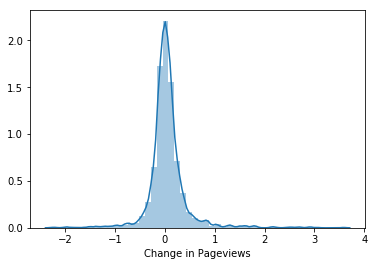

In [103]:
sns.distplot(df_pazzo['Change in Pageviews'])

In [ ]:
df_